Train a model for [hand sign images](https://www.kaggle.com/datasets/ash2703/handsignimages) dataset using MobileNet for transfer learning.

#Import Dependencies

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import string
import random
from random import randint
import cv2 as cv
import os
import itertools

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet
from keras import models
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D,AveragePooling2D
from keras.layers import Dense,Dropout,Activation,Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, classification_report

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Create main variables

In [ ]:
root_path = '/content/drive/MyDrive/Universidad/Deep_Learning/Final_Project'

data_path = root_path + '/Dataset'

train_path = data_path + "/Train"
test_path = data_path + "/Test"

target_size_width = 32 #depends on MobileNet input
target_size_height = 32
input_shape = (target_size_height, target_size_width)

batch_size = 128
num_classes = 24 #All letters excluding J and Z
epochs = 10
split = 0.3

#Preprocess Dataset

In [ ]:
def gray_to_rgb(img):
    return np.repeat(img, 3, 2)

In [ ]:
#train_datagen = ImageDataGenerator(rescale = 1/255, validation_split = split, preprocessing_function=gray_to_rgb)

#test_datagen = ImageDataGenerator(rescale = 1/255, preprocessing_function=gray_to_rgb)

train_datagen = ImageDataGenerator(rescale = 1/255, validation_split = split)

test_datagen = ImageDataGenerator(rescale = 1/255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = input_shape,
    batch_size = batch_size,
    class_mode = "sparse",
    color_mode='rgb',
    subset = 'training'
    )

validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = input_shape,
    batch_size = batch_size,
    class_mode = "sparse",
    color_mode='rgb',
    subset = 'validation'
    )

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size = input_shape,
    batch_size = batch_size,
    class_mode = "sparse",
    color_mode='rgb'
    )

Found 19229 images belonging to 24 classes.
Found 8226 images belonging to 24 classes.
Found 7172 images belonging to 24 classes.


In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(10,10))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img[:,:,0])
        ax.axis('off')
    plt.tight_layout()
    plt.show()

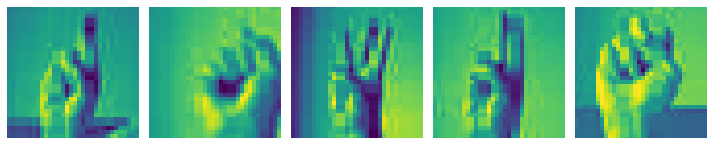

In [ ]:
sample_training_images, _ = next(train_generator)
plotImages(sample_training_images[:5])

#Create Neural Network Architecture

In [ ]:
 # imports the mobilenet model and discards the last 1000 neuron layer.
base_model = MobileNet(input_shape=(32,32,3), weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)  # we add dense layers so that the model can learn more complex functions and classify for better results.
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)  # dense layer 2
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)  # dense layer 3
x = Dropout(0.2)(x)

preds = Dense(num_classes, activation='softmax')(x)  # final layer with softmax activation

model = Model(inputs=base_model.input, outputs=preds)


model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 16, 16, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 16, 16, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 16, 16, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 16, 16, 32)       128       
 ation)                                                    

#Training

In [ ]:
#Se puede programar el entrenamiento para que haga un early stopping que dependa del error de validación
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

#Se puede configurar para que guarde el mejor modelo que se dé durante el entrenamiento, mejor dependiendo el error de validación.
mcp_save = ModelCheckpoint(root_path+'/keras-models/'+str(time.time())+"-weights-check.h5", save_best_only=True, monitor='val_loss', mode='min')

#Reduce el LR si se queda estancado el entrenamiento, basándose en el error de validación
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

In [ ]:
model.compile(
    #optimizer = RMSprop(lr = 0.001),
    optimizer = 'adam',
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks = [earlyStopping, mcp_save, reduce_lr_loss],
    validation_data = validation_generator
)

Epoch 1/10
151/151 [==============================] - 5991s 40s/step - loss: 1.6995 - accuracy: 0.5054 - val_loss: 1.9577 - val_accuracy: 0.4267 - lr: 0.0010
Epoch 2/10
151/151 [==============================] - 248s 2s/step - loss: 0.2203 - accuracy: 0.9379 - val_loss: 0.7870 - val_accuracy: 0.8181 - lr: 0.0010
Epoch 3/10
151/151 [==============================] - 240s 2s/step - loss: 0.1497 - accuracy: 0.9668 - val_loss: 0.3017 - val_accuracy: 0.9420 - lr: 0.0010
Epoch 4/10
151/151 [==============================] - 242s 2s/step - loss: 0.0947 - accuracy: 0.9821 - val_loss: 0.1621 - val_accuracy: 0.9635 - lr: 0.0010
Epoch 5/10
151/151 [==============================] - 240s 2s/step - loss: 0.0723 - accuracy: 0.9845 - val_loss: 0.1285 - val_accuracy: 0.9718 - lr: 0.0010
Epoch 6/10
151/151 [==============================] - 242s 2s/step - loss: 0.0741 - accuracy: 0.9855 - val_loss: 0.0191 - val_accuracy: 0.9964 - lr: 0.0010
Epoch 7/10
151/151 [==============================] - 243s 2s/

#Evaluate

In [ ]:
results = model.evaluate(test_generator)

57/57 [==============================] - 2241s 40s/step - loss: 0.7118 - accuracy: 0.9200


#Results

Create function to graph results.

In [ ]:
def plot_history(Exp_history, epochs):
  plt.figure(1)
  plt.subplot(211)
  plt.plot(list(range(1, epochs+1)),Exp_history.history['accuracy'])
  plt.plot(list(range(1, epochs+1)),Exp_history.history['val_accuracy'])
  plt.title('Accuracy')
  plt.ylabel('accuracy')
  plt.legend(['Train', 'Validation'], loc='best')
  plt.subplot(212)
  plt.plot(list(range(1, epochs+1)),Exp_history.history['loss'])
  plt.plot(list(range(1, epochs+1)),Exp_history.history['val_loss'])
  plt.title('Loss')
  plt.ylabel('loss')
  plt.xlabel('epoches')
  plt.legend(['Train', 'Validation'], loc='best')
  plt.tight_layout()
  plt.show()

Plot the performance of the network during training using the *accuracy* and the *loss* metrics.

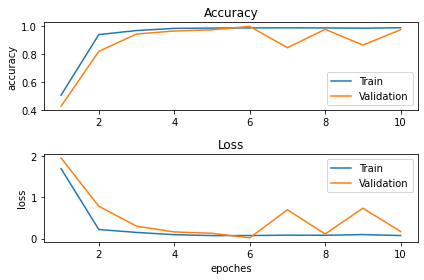

In [ ]:
plot_history(history,epochs)

#Save model

Save the final model after the training.

In [ ]:
model.save(root_path+'/keras-models/'+str(time.time())+"_STL_trainModel.h5")